In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

c:\Users\PNC\anaconda3\envs\Project_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = './Data/'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')
submission_df = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [3]:
train_df.head(30)

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
7,TRAIN_0000007,rih[.]p[.]se,0
8,TRAIN_0000008,microsoft[.]ltda,0
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1


In [4]:
test_df.head()

,ID,URL
0,TEST_0000000,niquelarte[.]blogspot[.]com[.]es
1,TEST_0000001,northernmetalproducts[.]com
2,TEST_0000002,ga[.]de
3,TEST_0000003,florawww[.]eeb[.]uconn[.]edu/199300089[.]html
4,TEST_0000004,activecity[.]moscow


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB


In [6]:
train_df[train_df['URL'].isna()]

,ID,URL,label


In [7]:
train_df[train_df['label'].isna()]

,ID,URL,label


C:\Users\PNC\AppData\Local\Temp\ipykernel_9352\1986079669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = train_df['label'].value_counts().index,


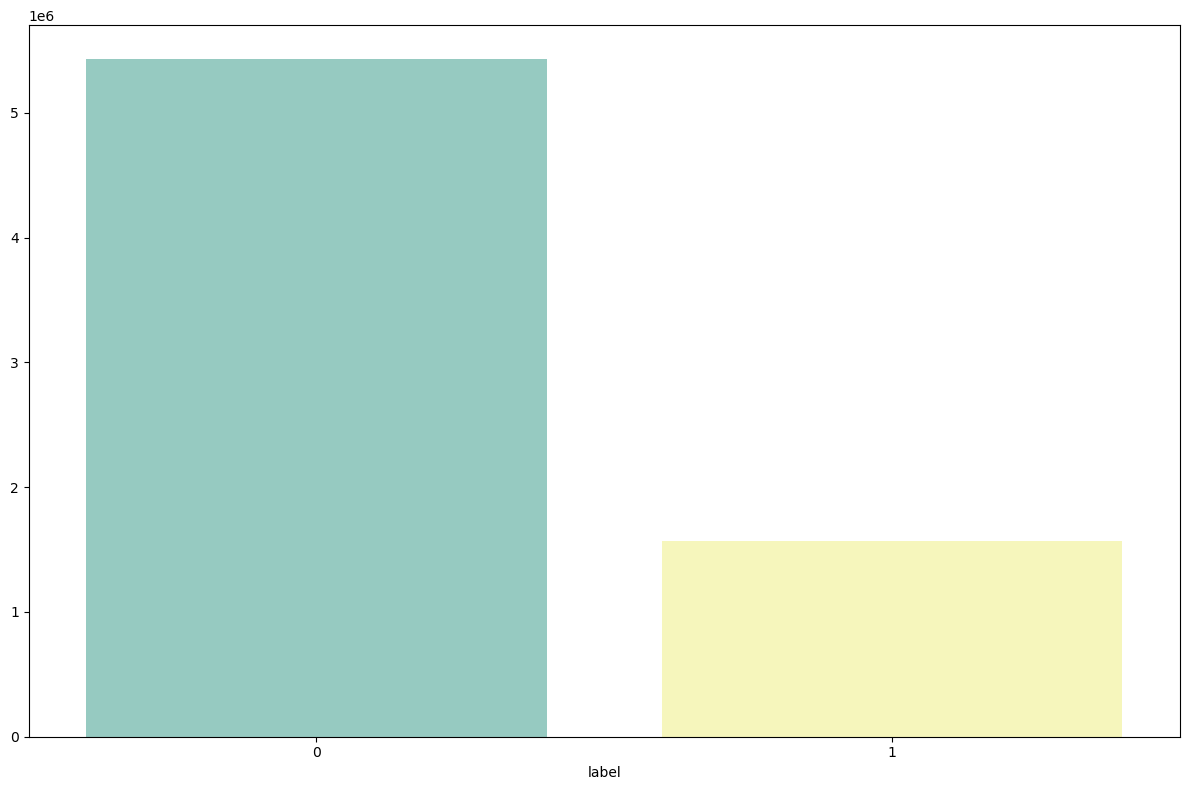

In [8]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.barplot(x = train_df['label'].value_counts().index,
            y = train_df['label'].value_counts().values,
            palette = 'Set3',
            ax = ax)
plt.tight_layout()
plt.show()

In [9]:
train_df[train_df['label'] == 1]

,ID,URL,label
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1
5,TRAIN_0000005,93fm[.]radio[.]br/file,1
6,TRAIN_0000006,ps[.]com[.]vu/wp-config/wp-incluides/soft/ursn...,1
9,TRAIN_0000009,165[.]232[.]173[.]145/mobile[.]html,1
12,TRAIN_0000012,apollo[.]baby,1
...,...,...,...
6995033,TRAIN_6995033,posts-8012419782[.]smarttechno[.]hr,1
6995044,TRAIN_6995044,rthe[.]top/,1
6995047,TRAIN_6995047,www2[.]ml[.]meiceaord[.]com,1
6995050,TRAIN_6995050,10rtggdoffice[.]duckdns[.]org,1


In [10]:
train_df['URL'] = train_df['URL'].apply(lambda x: x.replace('[.]', '.'))
test_df['URL'] = test_df['URL'].apply(lambda x: x.replace('[.]', '.'))

In [11]:
def tokenize_url(url):
    tokens = re.split(r'[\W_]+', url)
    return [t.lower() for t in tokens]

train_url = train_df['URL']
train_url = [tokenize_url(url) for url in train_url]

test_url = test_df['URL']
test_url = [tokenize_url(url) for url in test_url]

train_url

[['poznan', 'wuoz', 'gov', 'pl'],
 ['vill', 'okawa', 'kochi', 'jp'],
 ['nationalfinance', 'co', 'om'],
 ['town', 'ozora', 'hokkaido', 'jp'],
 ['open24', 'ie', 'news', 'irish', 'online', 'login'],
 ['93fm', 'radio', 'br', 'file'],
 ['ps', 'com', 'vu', 'wp', 'config', 'wp', 'incluides', 'soft', 'ursnbxmmvd'],
 ['rih', 'p', 'se'],
 ['microsoft', 'ltda'],
 ['165', '232', '173', '145', 'mobile', 'html'],
 ['', 'www', 'vanylven', 'no'],
 ['pref', 'kagawa', 'jp'],
 ['apollo', 'baby'],
 ['adonis', 'holdings'],
 ['jalawave', 'net', 'id'],
 ['hiroshima', 'jp'],
 ['town', 'hiroo', 'hokkaido', 'jp'],
 ['nic', 'weather'],
 ['nsa', 'community'],
 ['allegro', 'tm', 'pl'],
 ['championsleague', 'basketball'],
 ['cmsjm', 'rj', 'gov', 'br'],
 ['wcape', 'school', 'za'],
 ['town', 'yugawara', 'kanagawa', 'jp'],
 ['global', 'net', 'pg', 'diocese', 'of', 'aitape', 'aitape', 'htm'],
 ['vill', 'ogimi', 'okinawa', 'jp'],
 ['oldham', 'sch', 'uk'],
 ['city', 'makinohara', 'shizuoka', 'jp'],
 ['kagoshima', 'jp'],


In [12]:
def url_to_vector(url, model):
    vectors = [model.wv[token] for token in url if token in model.wv]  # Word2Vec에서 벡터 찾기
    if vectors:
        return np.mean(vectors, axis = 0)  # 여러 단어의 평균 벡터
    else:
        return np.zeros(model.vector_size)  # 단어가 없으면 0 벡터 반환


In [13]:
word2vec_model = Word2Vec(sentences = train_url, vector_size = 100, window = 5, min_count = 1, sg = 1, workers = 5)

train_url = [url_to_vector(url, word2vec_model) for url in train_url]  # Train 데이터를 벡터로 변환
test_url = [url_to_vector(url, word2vec_model) for url in test_url]




In [14]:
train_url

[array([ 0.10429588, -0.87085336,  0.28215212, -0.284107  ,  0.8448234 ,
         0.7352638 ,  0.09374931,  1.1032617 ,  0.71597207, -1.2402962 ,
        -1.7792445 , -1.7885115 , -0.70335037, -0.14858504,  0.4263988 ,
         1.3275695 , -1.5994406 ,  0.20758292,  0.1565983 , -0.5259168 ,
        -0.29169965,  0.47766098, -0.22232223,  1.4106648 ,  1.2841046 ,
         1.2296288 , -0.28268588, -0.3139364 , -0.20069301,  0.9184135 ,
        -1.0166848 ,  0.6874281 , -0.43647978, -1.1251558 ,  0.1309737 ,
         1.084883  , -0.19829902, -0.46549082, -1.5957819 ,  0.26410848,
        -0.5907103 ,  0.9090487 , -1.7194612 , -0.20927271, -0.3074292 ,
        -2.5629694 ,  0.5883607 , -0.5361342 , -0.6794097 ,  0.3565178 ,
        -0.02592301, -0.402071  , -0.8244255 ,  0.79579747, -1.3819554 ,
         0.75014687, -1.3531492 , -1.1653088 , -0.6898675 , -0.37699497,
        -0.52701265, -0.6776279 ,  0.86003965,  0.53363   ,  0.6572148 ,
         0.02250111, -0.99482286,  0.90055   , -0.9

In [21]:
test_df['label'] = None

test_df.head()

,URL,label
0,"[0.3995911, -2.3245363, -1.2509588, 0.4270755,...",None
1,"[0.078822635, -0.041876603, 0.30728483, 0.1544...",None
2,"[0.6629453, -1.111097, 1.1563327, 0.17487746, ...",None
3,"[0.62299335, -0.8106642, 1.561023, -1.2727985,...",None
4,"[-0.39052188, -0.50185406, 0.55905545, -0.3363...",None


In [ ]:
class TextDataset(Dataset):
    def __init__(self, df):
        self.url = df["URL"].values 
        self.label = df["label"].values if df["label"] is not None else None

    def __len__(self):
        return len(self.url)
    
    def __getitem__(self, index):
        if self.label is not None:
            return (torch.tensor(self.url[index], dtype = torch.float),
                    torch.tensor(self.label[index], dtype = torch.long))
        else:
            return torch.tensor(self.url[index], dtype = torch.float)

In [16]:
train_df = train_df.drop('ID', axis = 1)
test_df = test_df.drop('ID', axis = 1)



In [17]:
train_df['URL'] = train_url
test_df['URL'] = test_url

In [18]:
train_df['URL']

0          [0.10429588, -0.87085336, 0.28215212, -0.28410...
1          [1.0387477, -0.5613866, 1.0837784, -0.100117, ...
2          [0.06836468, -0.9365943, 1.1372603, -0.0411340...
3          [0.98049194, -0.76920086, 1.1369421, -0.253600...
4          [0.27806985, -0.3575565, 1.0824176, -0.8773122...
                                 ...                        
6995051    [1.0660874, -1.530892, 1.5496987, 0.51496285, ...
6995052    [0.6352294, -0.54781, 0.47150466, -0.091305606...
6995053    [0.087276384, -0.2067472, 0.4852366, -0.264795...
6995054    [0.08120208, -0.034563083, 0.3152295, 0.157778...
6995055    [0.07328589, -0.036608063, 0.31227115, 0.16408...
Name: URL, Length: 6995056, dtype: object

In [23]:
train_data, val_data = train_test_split(
                                    train_df,
                                    test_size = 0.2, 
                                    random_state = 7
                                )

train_dataset = TextDataset(train_data)
val_dataset = TextDataset(val_data)
test_dataset = TextDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 256, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)

In [24]:
class URLClassifier(nn.Module):
    def __init__(self, in_in, in_out, out_out, dropout_prob, h_ins = [], h_outs = []):
        super().__init__()

        self.in_layer = nn.Linear(in_in, h_ins[0] if len(h_ins) else in_out)
        self.in_bn = nn.BatchNorm1d(h_ins[0] if len(h_ins) else in_out)
        self.dropout = nn.Dropout(dropout_prob)
        
        self.h_layers = nn.ModuleList()
        for idx in range(len(h_ins) - 1):
            self.h_layers.append(nn.Linear(h_ins[idx], h_outs[idx + 1]))
            self.h_layers.append(nn.BatchNorm1d(h_outs[idx + 1]))
            self.h_layers.append(nn.ReLU())
            self.h_layers.append(nn.Dropout(dropout_prob))

        self.out_layer = nn.Linear(h_outs[-1] if len(h_outs) else in_out, out_out)

    def forward(self, input_data):

        y = F.relu(self.in_bn(self.in_layer(input_data)))
        y = self.dropout(y)
        for linear in self.h_layers:
            y = linear(y)
        return F.sigmoid(self.out_layer(y))


In [25]:
in_in = 100
in_out = 100
out_out = 1
h_inouts = [128, 256, 256, 128]
dropout = 0.2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


model = URLClassifier(in_in = in_in, in_out = in_out, 
                      out_out = out_out, dropout_prob = dropout,
                      h_ins = h_inouts, h_outs = h_inouts).to(DEVICE)

EPOCH = 100
LR = 0.001

BCEloss = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr = LR)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience = 10, verbose = True)


In [27]:
def testing(test_loader):
    model.eval()
    test_loss, test_f1 = 0, 0

    with torch.no_grad():
        for test_url, test_label in test_loader:
            test_url, test_label = (test_url.to(DEVICE), test_label.to(DEVICE))
            pre_y = model(test_url)

            test_label = test_label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, test_label)
            test_loss += loss.item()

            score = BinaryF1Score().to(DEVICE)(pre_y, test_label)
            test_f1 += score.item()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_f1 = test_f1 / len(test_loader)

    return avg_test_loss, avg_test_f1

In [31]:
SAVE_PATH = './saved_models/'
os.makedirs(SAVE_PATH, exist_ok = True)

def training(train_loader, test_loader):
    BREAK_CNT_LOSS = 0
    BREAK_CNT_SCORE = 0
    LIMIT_VALUE = 10

    LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]

    for epoch in range(EPOCH):

        model.train()

        SAVE_MODEL = os.path.join(SAVE_PATH, f'model_{epoch}.pth')
        SAVE_FILE = os.path.join(SAVE_PATH, f'model_weights_{epoch}.pth')

        loss_total, score_total = 0, 0

        for url, label in train_loader:
            url, label = (url.to(DEVICE), label.to(DEVICE))

            pre_y = model(url)
            label = label.reshape(-1, 1).float()

            loss = BCEloss(pre_y, label)
            loss_total += loss.item()

            score = BinaryF1Score().to(DEVICE)(pre_y, label)
            
            score_total += score.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:  # 예시로 10 epoch마다 출력
            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f'Epoch {epoch + 1}, Gradient for {name}: {param.grad.abs().mean().item()}')


        test_loss, test_f1 = testing(test_loader)

        LOSS_HISTORY[1].append(test_loss)
        SCORE_HISTORY[1].append(test_f1)

        LOSS_HISTORY[0].append(loss_total / len(train_loader))
        SCORE_HISTORY[0].append(score_total / len(train_loader))

        print(f"[{epoch + 1}/{EPOCH}]\n - TRAIN LOSS : {LOSS_HISTORY[0][-1]} TRAIN F1 : {SCORE_HISTORY[0][-1]}")
        print(f"- TEST LOSS : {LOSS_HISTORY[1][-1]} TEST F1 : {SCORE_HISTORY[1][-1]}")

        scheduler.step(test_f1)

            # 학습 진행 모니터링/스케쥴링 - 검증 DS 기준
        # Score 기준
        if len(SCORE_HISTORY[1]) >= 2:
            if SCORE_HISTORY[1][-1] >= SCORE_HISTORY[1][-2]: BREAK_CNT_SCORE += 1

        # 성능이 좋은 학습 가중치 저장

        if len(SCORE_HISTORY[1]) == 1:
            # 첫 번째라서 무조건 모델 파라미터 저장
            torch.save(model.state_dict(), SAVE_FILE)

        else:
            if SCORE_HISTORY[1][-1] > max(SCORE_HISTORY[1][:-1]):
                torch.save(model.state_dict(), SAVE_FILE)

        if BREAK_CNT_LOSS > LIMIT_VALUE:
            print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
            break

    return LOSS_HISTORY, SCORE_HISTORY


In [33]:
loss, f1 = training(train_loader, val_loader)

Epoch 1, Gradient for in_layer.weight: 0.0019939185585826635
Epoch 1, Gradient for in_layer.bias: 5.774438704975182e-10
Epoch 1, Gradient for in_bn.weight: 0.003987997770309448
Epoch 1, Gradient for in_bn.bias: 0.005062926094979048
Epoch 1, Gradient for h_layers.0.weight: 0.00011074519716203213
Epoch 1, Gradient for h_layers.0.bias: 9.184120131067175e-11
Epoch 1, Gradient for h_layers.1.weight: 0.0008583875605836511
Epoch 1, Gradient for h_layers.1.bias: 0.0010052641155198216
Epoch 1, Gradient for h_layers.4.weight: 2.629712071211543e-05
Epoch 1, Gradient for h_layers.4.bias: 1.2893686118786718e-11
Epoch 1, Gradient for h_layers.5.weight: 0.0003592083521652967
Epoch 1, Gradient for h_layers.5.bias: 0.00044703157618641853
Epoch 1, Gradient for h_layers.8.weight: 2.2046770027372986e-05
Epoch 1, Gradient for h_layers.8.bias: 1.1723955140041653e-11
Epoch 1, Gradient for h_layers.9.weight: 0.0004548393771983683
Epoch 1, Gradient for h_layers.9.bias: 0.0009728635777719319
Epoch 1, Gradient f

In [34]:
MODEL_PATH = './saved_models/'

model = URLClassifier(in_in = in_in, in_out = in_out, 
                      out_out = out_out, dropout_prob = dropout,
                      h_ins = h_inouts, h_outs = h_inouts)

model.load_state_dict(torch.load(MODEL_PATH + 'model_weights_93.pth', weights_only = True, map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
for X_batch in test_loader:
    print(X_batch)
    break

In [36]:
model.eval()

y_test_preds = []

with torch.no_grad():
    for X_batch in test_loader:
        outputs = model(X_batch).squeeze()
        y_test_preds.extend(outputs.cpu().numpy())

submission = pd.DataFrame({"ID": test_df["ID"], "probability": y_test_preds})
submission.to_csv("submission_6th.csv", index=False)

TypeError: an integer is required (got type NoneType)